<a href="https://colab.research.google.com/github/Hayden-Trautmann/MR-Image-Preprocessing/blob/main/T1_3__denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
os.chdir('/content/drive/My Drive/cse320/datasets/')

!pip install nilearn -q
!pip install nibabel -q
!pip install --upgrade certifi -q
!pip install medpy -q

#import packages
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import datasets, plotting, image
import cv2
from google.colab.patches import cv2_imshow
from medpy.filter.smoothing import anisotropic_diffusion
%matplotlib inline

Mounted at /content/drive
     |████████████████████████████████| 10.0 MB 4.9 MB/s 
     |████████████████████████████████| 151 kB 5.3 MB/s 
     |████████████████████████████████| 48.4 MB 5.1 kB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
#read .rawb format data for clean images
clean = np.fromfile('clean_img/t1.rawb', dtype='uint8');

#read .rawb format data for unclean images with 3% noise
unclean = np.fromfile('unclean_img/t1_pn3.rawb', dtype='uint8');

98.48453723857519
106.96514391664873


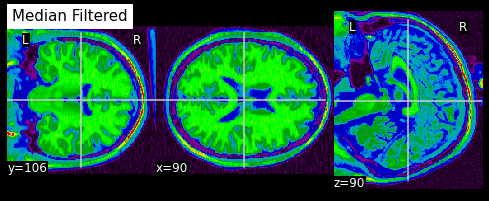

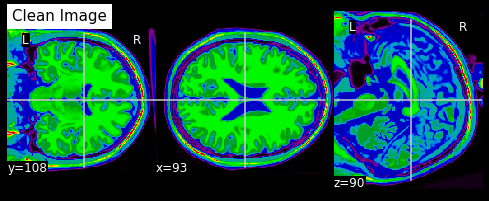

In [ ]:
# Median Filtering to remove salt+pepper noise

#median filter .rawb data with kernel of 5
def median(data):
  median_filter = cv2.medianBlur(data,5)
  return median_filter

# Function for converting .rawb data into .nii image format.
def to_nii(data):
  #reshape vectorized data into 3D array
  shaped_data = data.reshape(181,217,181)

  #Affine image and transform into nii format (multidimensional data format)
  raw_affine = np.diag([1,1,1,1]) #try [-1,-1,1,1] later?
  img_nii = nib.Nifti1Image(shaped_data, raw_affine)
  return img_nii

#Calculate Coefficient of Variation
# Converts nii formatted image to NumPy array, then calculate and print CV
# Parameter: nii - nii formatted image

def cv(nii):
  #define function to calculate CV
  cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

  #convert nii image to np array
  data = nii.get_fdata()
  
  #calculate CV
  print(cv(data))


#median filter 3% noise
filtered = median(unclean)

#convert rawb to nii for plotting
filtered_nii = to_nii(filtered)
#check Coefficient of Variation
cv(filtered_nii)
#plot image
plotting.plot_epi(filtered_nii,title="Median Filtered")

#Plot clean image and check its coefficient of variation
#convert rawb to nii for plotting
clean_nii = to_nii(clean)
#check Coefficient of Variation
cv(clean_nii)
#plot image
plotting.plot_epi(clean_nii,title="Clean Image")

96.47437523152416
92.42900626798829


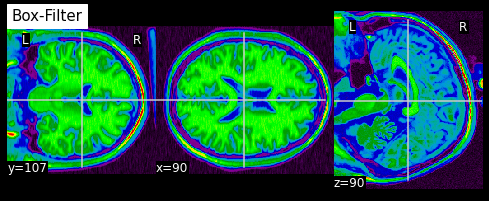

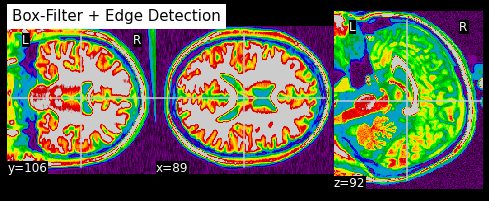

In [ ]:
# Denoise using Box Filtering 
def box_kernel(size):
  kernel = np.ones((size,size),np.float32)/(size**2)
  return kernel

# Denoise the image using Box filtering
# Will use a 5 by 5 kernel.
box_filter_img = cv2.filter2D(unclean, -1, box_kernel(5))
#convert to nii for plotting
box_nii = to_nii(box_filter_img)
plotting.plot_epi(box_nii,title="Box-Filter")
cv(box_nii)

#sharpen image with edge detection
image_sharp = cv2.filter2D(src=box_filter_img, ddepth=-1, kernel=2)
box_and_edge_nii = to_nii(image_sharp)
plotting.plot_epi(box_and_edge_nii,title="Box-Filter + Edge Detection")
cv(box_and_edge_nii)

/usr/local/lib/python3.7/dist-packages/nilearn/image/image.py:217: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  .format(fwhm))


99.7739373209925
96.48133595600389
91.75862801250346
87.51423242070295
83.93511888704704


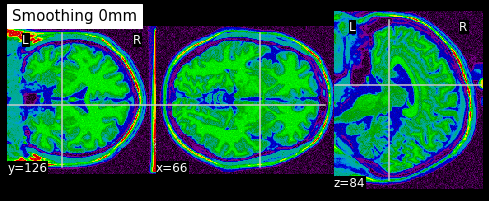

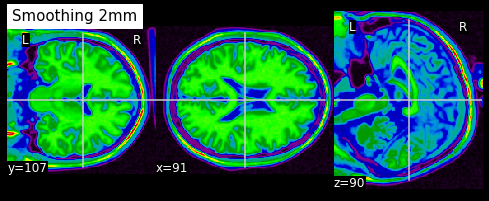

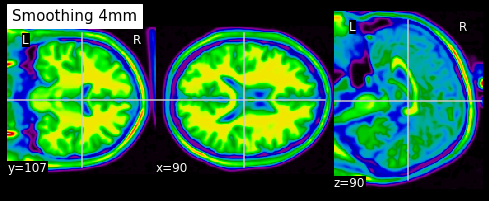

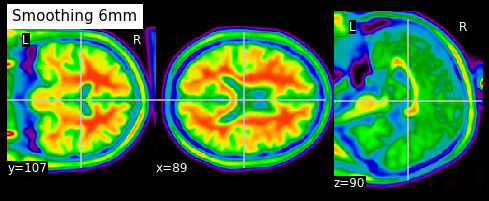

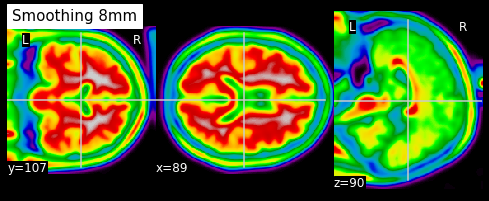

In [ ]:
# Denoise using Gaussian - Find best fwhm

#convert to nii format before Gaussian smoothing
unclean_nii= to_nii(unclean)
#compute the mean image for 9% noise
mean_unclean = image.mean_img(unclean_nii)
mean_unclean.shape

#Gaussian smoothing by increments of 1mm
for smoothing in range(0, 10, 2):
  smoothed_unclean = image.smooth_img(mean_unclean, smoothing)
  cv(smoothed_unclean)
  plotting.plot_epi(smoothed_unclean,title="Smoothing %imm" % smoothing)

88.70550056370926


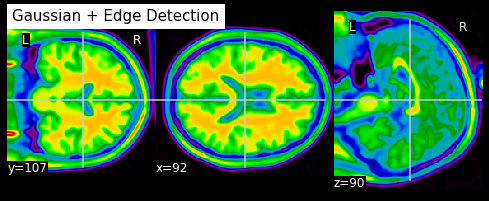

In [ ]:
#edge detection on best result of 5mm as fwhm
gauss_smooth = image.smooth_img(mean_unclean, 5)
#change format from nii after smoothing
gauss_smooth_raw = gauss_smooth.get_fdata()

#set kernel to 3 for sharpening
gauss_sharp = cv2.filter2D(src=gauss_smooth_raw, ddepth=-1, kernel=5)
gauss_and_edge_nii = to_nii(gauss_sharp)
plotting.plot_epi(gauss_and_edge_nii,title="Gaussian + Edge Detection")
cv(gauss_and_edge_nii)


/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


99.7739373209925


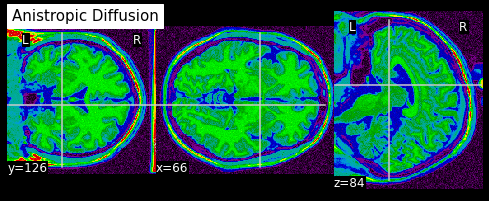

In [ ]:
#Anistropic Filtering
affine = unclean_nii.affine
anistropic_img = anisotropic_diffusion(unclean)

#convert to nii format for affine
anistropic_nii = to_nii(unclean)

#calculate CV 
cv(anistropic_nii)

#plot image next to clean to compare
plotting.plot_epi(anistropic_nii,title="Anistropic Diffusion")